Homework 2: Housing Pricing

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


####PART TWO: A fresh start with a slightly better dataset

Please excuse the lack of data exploration my code didnt save on colab and I only had time to recreate the model when preparing for the presentation.

In [ ]:
!pip install kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat 'kaggle.json': No such file or directory


### Imports

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

datapath = "/content/drive/MyDrive/Github/HousingPrice/data/"

### Load the Data
Generate the target, testing, and combined dataframes

In [ ]:
house_data = pd.read_csv('/content/drive/MyDrive/Github/HousingPrice/amesData/AmesHousing.csv')
test = pd.read_csv('/content/drive/MyDrive/Github/HousingPrice/data/test.csv')
data_w = house_data.copy()
data_w.columns = data_w.columns.str.replace(' ', '') # Replacing the white spaces in columns' names
data_w.info()

target = data_w['SalePrice'] # Sale Price Dataframe
test_id = test['Id'] # Removing Id from the Ames Dataset
test = test.drop(['Id'],axis = 1) # Testing Dataframe
data_w2 = data_w.drop(['SalePrice','Order','PID'], axis = 1)
combined = pd.concat([data_w2,test], axis=0, sort=False) # Create the combined dataset # Range?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order          2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   MSSubClass     2930 non-null   int64  
 3   MSZoning       2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 18  OverallQ

In [ ]:
combined.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,YearRemodAdd
count,4389.00000,3672.000000,4389.000000,4389.000000,4389.000000,4389.000000,2930.000000,4351.000000,4387.000000,4387.000000,...,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,1459.000000
mean,57.38437,69.008442,10038.634541,6.089542,5.560036,1971.356801,1984.266553,101.502643,441.490996,50.685206,...,93.560036,47.792891,23.421053,2.327182,16.355206,2.077466,53.139212,6.178856,2007.783550,1983.662783
std,42.66937,23.037371,7044.993407,1.419506,1.112151,30.290079,20.860286,178.601035,455.434541,171.711906,...,126.808816,67.945124,65.176973,23.616631,56.257339,33.982520,588.495661,2.717335,1.311576,21.130467
min,20.00000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,1950.000000
25%,20.00000,58.000000,7424.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,1963.000000
50%,50.00000,68.000000,9430.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,363.000000,0.000000,...,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,1992.000000
75%,70.00000,80.000000,11553.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,739.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,2004.000000
max,190.00000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,2010.000000


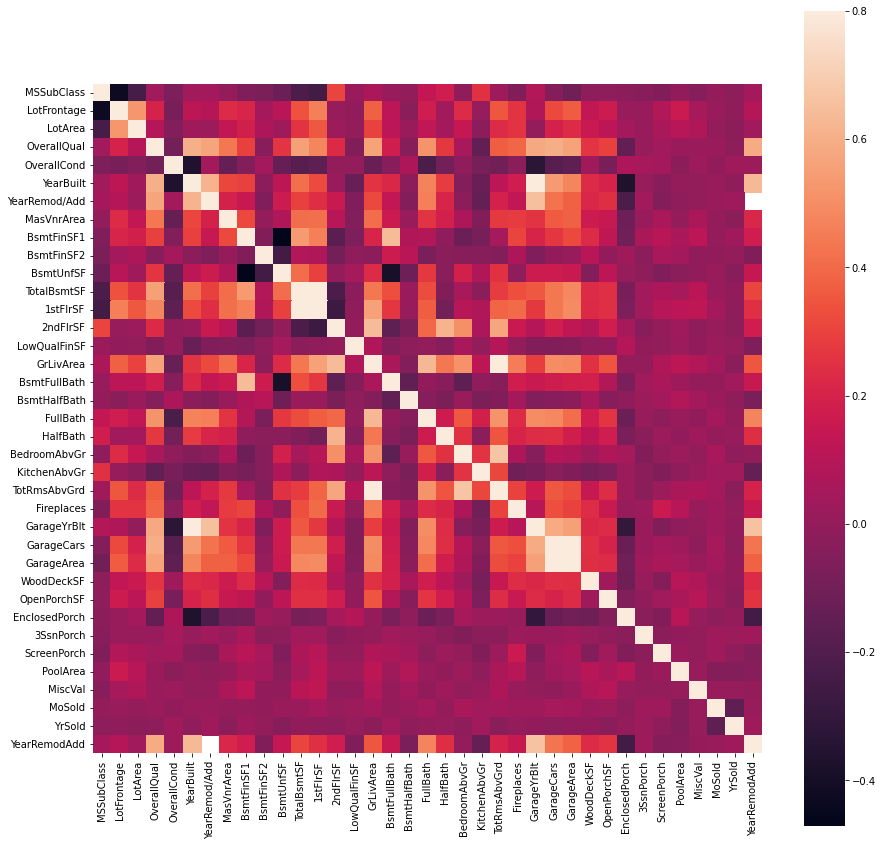

In [ ]:
C_mat = combined.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [ ]:
# Just want to be able to read mroe columns
pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 100)

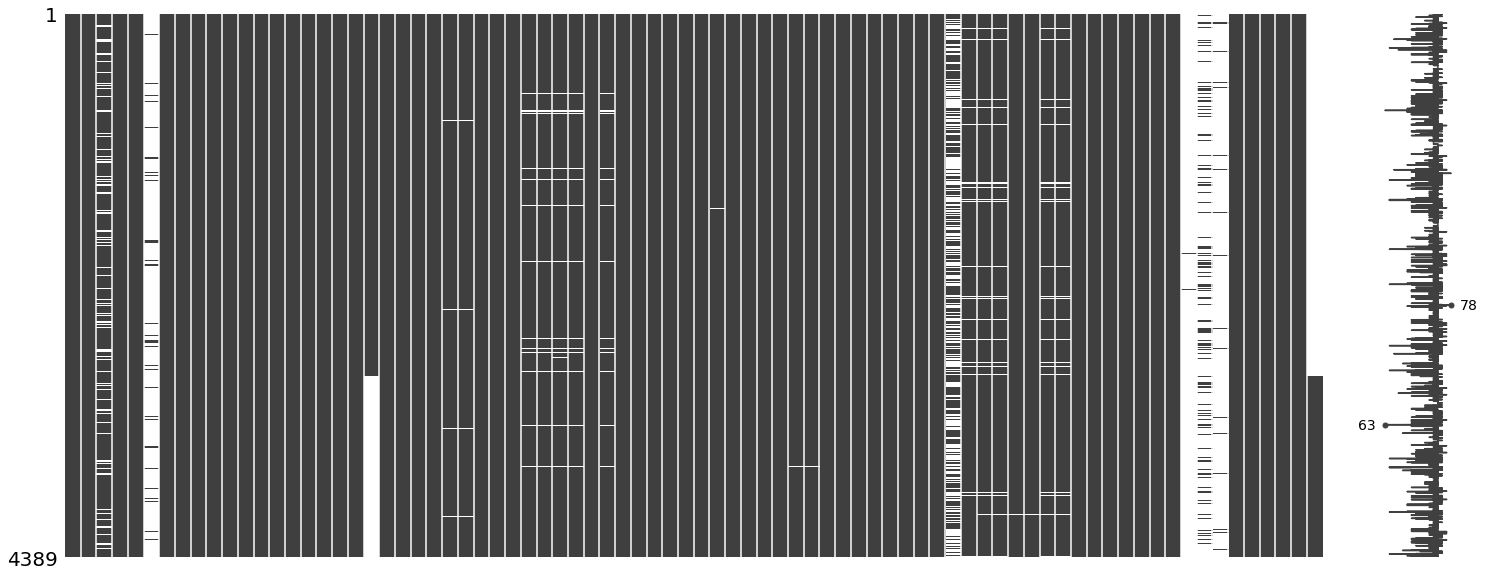

In [ ]:
import missingno as msno
msno.matrix(combined)

### Find Missing Databased on percentage
https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python 

In [ ]:
#missing data
total = combined.isnull().sum().sort_values(ascending=False)
percent = (combined.isnull().sum()/combined.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(79)

,Total,Percent
PoolQC,4373,0.996355
MiscFeature,4232,0.964229
Alley,4084,0.930508
Fence,3527,0.803600
YearRemodAdd,2930,0.667578
FireplaceQu,2152,0.490317
YearRemod/Add,1459,0.332422
LotFrontage,717,0.163363
GarageQual,237,0.053999
GarageCond,237,0.053999


Filling in Missing Data Regarding Categorical Columns

In [ ]:
# Converting non-numeric predictors stored as numbers into string
# We want these columns to function as categorical columns
combined['MSSubClass'] = combined['MSSubClass'].apply(str)
combined['YrSold'] = combined['YrSold'].apply(str)
combined['MoSold'] = combined['MoSold'].apply(str)

# Filling Categorical NaN (That we know how to fill due to the description file )

# Manually filled these because they are imporant features
combined['Functional'] = combined['Functional'].fillna('Typ')
combined['Electrical'] = combined['Electrical'].fillna("SBrkr")
combined['KitchenQual'] = combined['KitchenQual'].fillna("TA")

# Fill with the mode because its most like the others-
combined['Exterior1st'] = combined['Exterior1st'].fillna(combined['Exterior1st'].mode()[0])
combined['Exterior2nd'] = combined['Exterior2nd'].fillna(combined['Exterior2nd'].mode()[0])
combined['SaleType'] = combined['SaleType'].fillna(combined['SaleType'].mode()[0])

# If there is a house that does not have a certain features than it is empty so lets replace those.
combined["PoolQC"] = combined["PoolQC"].fillna("None")
combined["Alley"] = combined["Alley"].fillna("None")
combined['FireplaceQu'] = combined['FireplaceQu'].fillna("None")
combined['Fence'] = combined['Fence'].fillna("None")
combined['MiscFeature'] = combined['MiscFeature'].fillna("None")

#  If there is not garage or basement, add data stating its missing features
for col in ('GarageArea', 'GarageCars'):
    combined[col] = combined[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    combined[col] = combined[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    combined[col] = combined[col].fillna('None')

In [ ]:
objects = []
for i in combined.columns:
    if combined[i].dtype == object:
        objects.append(i)
combined.update(combined[objects].fillna('None'))

# Checking NaN presence
for col in combined:
    if combined[col].isna().sum() > 0:
        print(combined[col][0])

0    141.0
0     80.0
Name: LotFrontage, dtype: float64
0    1960.0
0       NaN
Name: YearRemod/Add, dtype: float64
0    112.0
0      0.0
Name: MasVnrArea, dtype: float64
0    639.0
0    468.0
Name: BsmtFinSF1, dtype: float64
0      0.0
0    144.0
Name: BsmtFinSF2, dtype: float64
0    441.0
0    270.0
Name: BsmtUnfSF, dtype: float64
0    1080.0
0     882.0
Name: TotalBsmtSF, dtype: float64
0    1.0
0    0.0
Name: BsmtFullBath, dtype: float64
0    0.0
0    0.0
Name: BsmtHalfBath, dtype: float64
0    1960.0
0    1961.0
Name: GarageYrBlt, dtype: float64
0       NaN
0    1961.0
Name: YearRemodAdd, dtype: float64


In [ ]:
# Since these features are highly correlated we can remove them
useless = ['GarageYrBlt','YearRemodAdd']
combined = combined.drop(useless, axis = 1)

### KNN Impute 
on the other missing data that is numerical Data

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def impute_knn(df):
    ttn = combined.select_dtypes(include=[np.number])
    ttc = combined.select_dtypes(exclude=[np.number])

    cols_nan = ttn.columns[ttn.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ttn.columns.difference(cols_nan).values     # columns w/n nan

    for col in cols_nan:
        imp_test = ttn[ttn[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ttn.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])

    return pd.concat([ttn,ttc],axis=1)

combined = impute_knn(combined)

In [ ]:
combined.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.00000,4389.000000,4389.000000,4389.000000,4389.000000,...,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000
mean,69.740670,10038.634541,6.089542,5.560036,1971.356801,1984.45172,101.500843,441.317886,50.662110,557.749647,...,0.593301,1.765778,472.587378,93.560036,47.792891,23.421053,2.327182,16.355206,2.077466,53.139212
std,22.376123,7044.993407,1.419506,1.112151,30.290079,18.98107,178.111156,455.402931,171.676178,438.657141,...,0.647737,0.766377,215.876091,126.808816,67.945124,65.176973,23.616631,56.257339,33.982520,588.495661
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7424.000000,5.000000,5.000000,1953.000000,1969.60000,0.000000,0.000000,0.000000,219.000000,...,0.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.200000,9430.000000,6.000000,5.000000,1973.000000,1989.00000,0.000000,363.000000,0.000000,462.000000,...,1.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80.000000,11553.000000,7.000000,6.000000,2001.000000,2002.00000,164.000000,739.000000,0.000000,801.000000,...,1.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.00000,1600.000000,5644.000000,1526.000000,2336.000000,...,4.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000


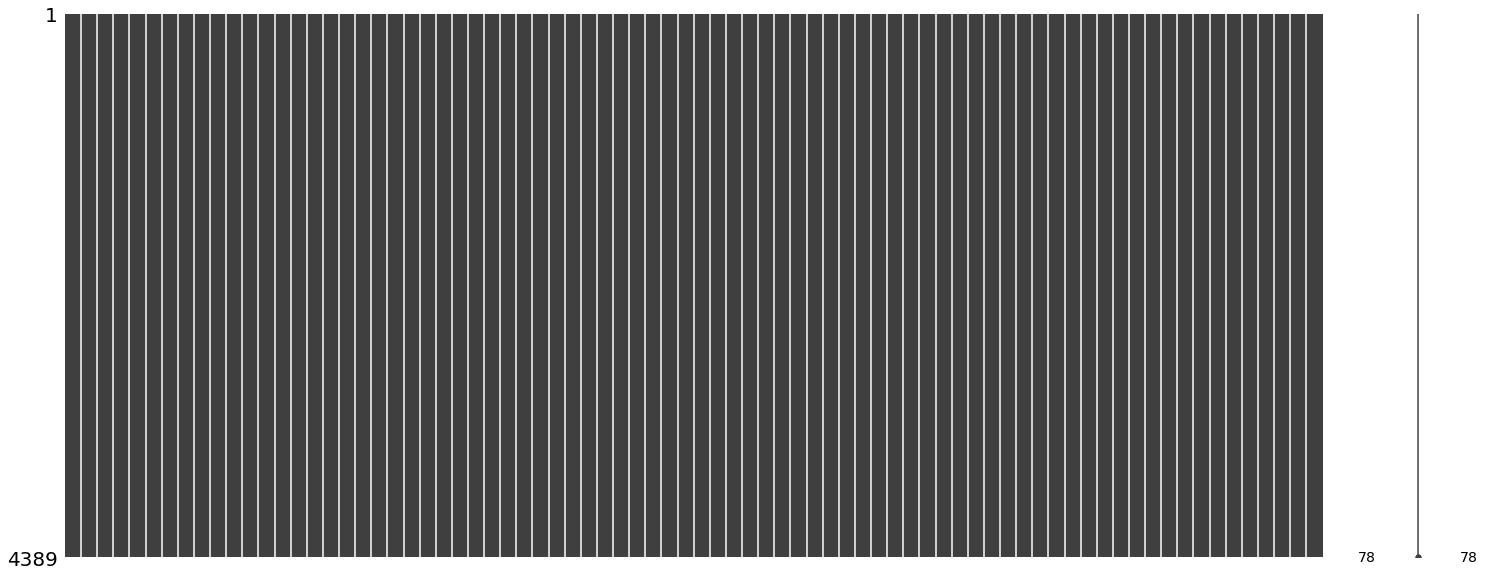

In [ ]:
import missingno as msno
msno.matrix(combined)

### Hot Encode Categorical columns

In [ ]:
# get list of categorical columns
cat_cols = list(combined.select_dtypes(include=['object']).columns)
print("Categorical columns: ", cat_cols)

# get list of numerical columns
num_cols = list(combined.select_dtypes(include=['number']).columns)
print("Numerical columns: ", num_cols)

Categorical columns:  ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Numerical columns:  ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'G

In [ ]:
# Perform one-hot encoding on the categorical columns
data_encoded = pd.get_dummies(combined, columns=cat_cols)

# Print the encoded dataframe
combined = data_encoded

In [ ]:
combined.shape

(4389, 350)

### Feature Engineer some more features

In [ ]:
def numericalFE(data): # May need to log skew these
  data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
  data['Bathrooms'] = data['FullBath'] + 0.5 * data['HalfBath']
  data['TotalPorchSF'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']
  data['TotalBathrooms'] = data['FullBath'] + data['HalfBath']
  data['TotalRooms'] = data['TotRmsAbvGrd'] + data['BedroomAbvGr'] + data['KitchenAbvGr']
  data['TotalArea'] = data['TotalSF'] + data['GarageArea'] + data['PoolArea']
  data['GarageSize'] = data['GarageCars'] * data['GarageArea']
  data['LotRatio'] = data['LotArea'] / data['TotalArea']
  data['PorchRatio'] = data['TotalPorchSF'] / data['TotalArea']
  data['OverallScore'] = data['OverallQual'] + data['OverallCond']
  data['LivLotRatio'] = data['GrLivArea'] / data['LotArea']
  return data

combined = numericalFE(combined)

In [ ]:
# Ensure that feature engineering features were added
combined.shape

(4389, 361)

In [ ]:
# Make sure target shape is the place of the split
target.shape

(2930,)

In [ ]:
def split_combined(df_split):
    train = df_split[:2930]
    test = df_split[2930:]

    return train , test
  
train, test = split_combined(combined)

In [ ]:
train.shape

(2930, 361)

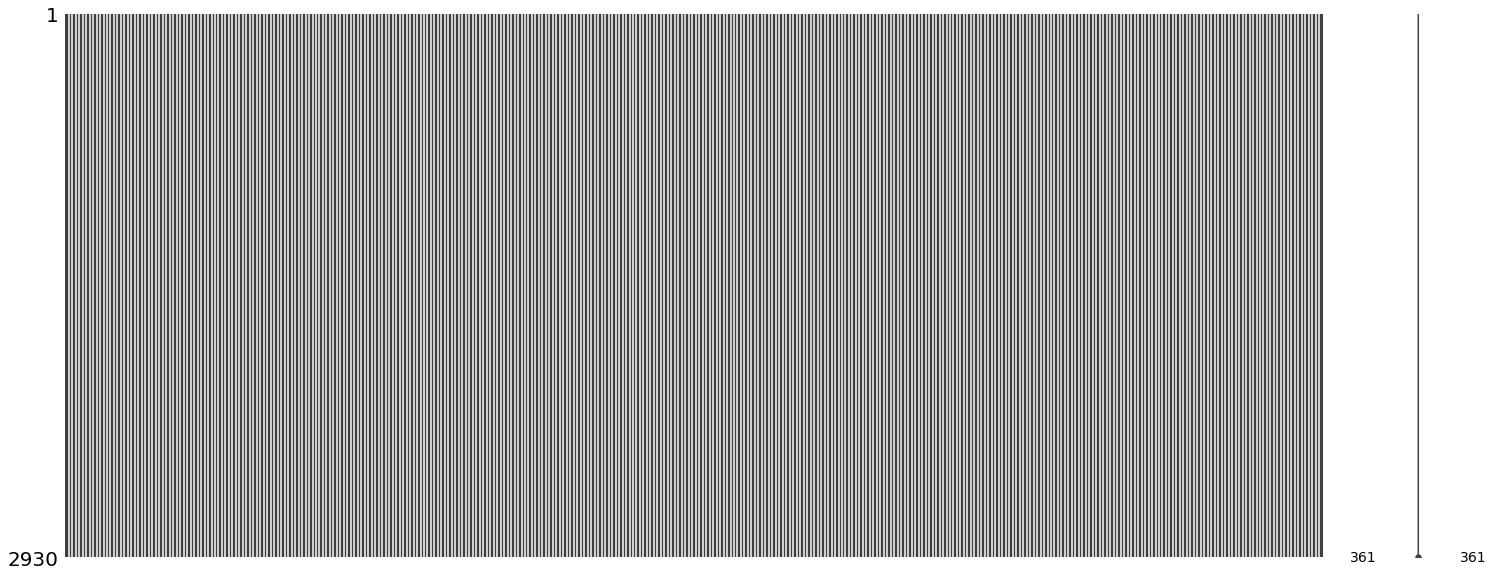

In [ ]:
msno.matrix(train)

In [ ]:
from keras.layers import Dropout
from tensorflow import keras
import tensorflow as tf
from keras import regularizers

### Optimizer
Fine tune the optimzers learning rate

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005, weight_decay=0.1)

### Sequential DL Model
Followed the same general architecture as the original data. 
Scaling up the neurons improved performance.

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(512, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(1024, kernel_regularizer=regularizers.L2(l2=0.05),activation='relu')) # kernal_initalizer= normal
NN_model.add(Dense(1024, kernel_regularizer=regularizers.L2(l2=0.05),activation='relu'))
NN_model.add(Dense(1024, kernel_regularizer=regularizers.L2(l2=0.05),activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               185344    
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 2,810,881
Trainable params: 2,810,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_name = 'Weights-{epoch:03d}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto') 
callbacks_list = [checkpoint]

In [ ]:
history = NN_model.fit(train, target, epochs=600, batch_size=32, validation_split = 0.2, callbacks=callbacks_list) # Saving to history allows us to find the training

Epoch 1/600
73/74 [============================>.] - ETA: 0s - loss: 59379.8164 - mean_absolute_error: 59282.9805
Epoch 1: val_loss improved from inf to 28349.17773, saving model to Weights-001.hdf5
74/74 [==============================] - 7s 17ms/step - loss: 59260.4219 - mean_absolute_error: 59163.6641 - val_loss: 28349.1777 - val_mean_absolute_error: 28274.6113
Epoch 2/600
72/74 [============================>.] - ETA: 0s - loss: 28693.5273 - mean_absolute_error: 28624.4062
Epoch 2: val_loss improved from 28349.17773 to 24798.47656, saving model to Weights-002.hdf5
74/74 [==============================] - 1s 12ms/step - loss: 28602.8711 - mean_absolute_error: 28533.8086 - val_loss: 24798.4766 - val_mean_absolute_error: 24732.9375
Epoch 3/600
70/74 [===========================>..] - ETA: 0s - loss: 27851.3477 - mean_absolute_error: 27787.4414
Epoch 3: val_loss improved from 24798.47656 to 24355.81836, saving model to Weights-003.hdf5
74/74 [==============================] - 1s 15ms/st

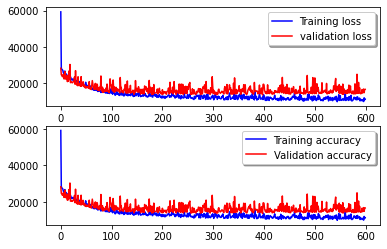

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['mean_absolute_error'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_mean_absolute_error'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Load wights file of the best model :
wights_file = 'Weights-398.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])

In [ ]:
import json
import os

kaggle_json = {"username":"crakowski","key":"f4d8199898aebdd7a20b0b2c93316f58"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(kaggle_json, file)

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':pd.read_csv('/content/drive/MyDrive/Github/HousingPrice/data/test.csv').Id,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name), index=False)
  print('A submission file has been made')

predictions = NN_model.predict(test) 
make_submission(predictions[:,0],'/content/drive/MyDrive/Github/HousingPrice/submissions/NN/submission(NN)_2')
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f "/content/drive/MyDrive/Github/HousingPrice/submissions/NN/submission(NN)_2.csv" -m "Kept regularizer and added weight decay of 0.1, but gave it 600 epochs since it trains at lower rate - only used 400 epoch"
!kaggle competitions submissions -c house-prices-advanced-regression-techniques

46/46 [==============================] - 0s 2ms/step
A submission file has been made
100% 21.1k/21.1k [00:00<00:00, 39.7kB/s]
Successfully submitted to House Prices - Advanced Regression TechniquesfileName              date                 description                                                                                                                 status    publicScore  privateScore  
--------------------  -------------------  --------------------------------------------------------------------------------------------------------------------------  --------  -----------  ------------  
submission(NN)_2.csv  2023-02-22 02:05:26  Kept regularizer and added weight decay of 0.1, but gave it 600 epochs since it trains at lower rate - only used 400 epoch  complete  0.09876                    
submission(NN)_2.csv  2023-02-22 02:02:13  Kept regularizer and added weight decay of 0.1, but gave it 600 epochs since it trains at lower rate                        complete  0.10853    

In [ ]:
!kaggle competitions submissions -c house-prices-advanced-regression-techniques

fileName              date                 description                                                                                                   status    publicScore  privateScore  
--------------------  -------------------  ------------------------------------------------------------------------------------------------------------  --------  -----------  ------------  
submission(NN)_2.csv  2023-02-22 02:02:13  Kept regularizer and added weight decay of 0.1, but gave it 600 epochs since it trains at lower rate          complete  0.10853                    
submission(NN)_2.csv  2023-02-22 01:54:00  Kept regularizer and added weight decay of 0.1                                                                complete  0.10853                    
submission(NN)_2.csv  2023-02-22 01:23:33  kept 512, 1024 architecture,  kernel_regularizer=regularizers.L2(l2=0.05)                                     complete  0.10063                    
submission(NN)_2.csv  2023-02-22 01:23:11  ke